<h1><center>
Rover project <br></center></h1>



<h2><center>Introduction</center></h2>

NASA’s Mars Curiosity Rover is a mobile robot that is exploring the Gale Crater on Mars to search areas of the red planet for past or present conditions favorable for life.<br>
The following data of the rover should be considered:

- Maximum velocity of the rover: $V_{max} = 0.04$ m/s <br>
- Wheel base: L = 3 m

All the code here presented has been developed in Python within a Jupyter Notebook. Data provided in `.mat` has been converted to `.csv` and loaded into the program. This Python program makes use of `numpy` and `matplotlib` to replicate MATLAB functionalities.


We begin by importing all needed modules to run the script. The custom imports that are specific to one task are marked with comments, otherwise assume that the import is used throughout the code. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# custom modules
from graph import *
from AStar import * # code for path planning task
from grid import *
from traj_gen import * # code for navigation task
from rover import *
from utils import *
from localization import * # code for localization task
from path import Path


For the operative ground, a 45x30 km map is provided in greyscale, with a resolution of 10m. Inaccessible regions are identified with a `255` (white) boundary margin.  
We load the data provided:

<center>
  
 `mars_map` contains the grayscale operative map. <br>
 `obstacle_map` containst the obstacle boundaries <br>
   `pos_lm` contains all landmark positions <br>

</center>

We also initialize all points of interest: <br>


<center>

&#128994; $P_0$ = (42.38, 11.59) km  <br>
&#128309; $P_1$ = (33.07, 19.01) km  <br>
&#128308; $P_2$  = (10.87, 25.67) km 

</center>

At last, we initialize a `Grid` object with the map, obstacles and landmarks provided. This class is responsible to do boundary checking and plotting. 

In [2]:
dataFolder = "data/"

## Constants of the problem
maxVel = 0.04; # [m/s] maximum velocity of the rover 
LAxis = 3; # [m] length of the rover wheel axis

# Points of interest
P0 = np.array([42.38*10**3, 11.59*10**3])
P1 = np.array([33.07*10**3, 19.01*10**3])
P2 = np.array([10.87*10**3, 25.67*10**3])
theta0 = np.deg2rad(90)
theta1 = np.deg2rad(180)

P0p = Path(P0, plotArgs='go')
P1p = Path(P1, plotArgs='bo')
P2p = Path(P2, plotArgs='ro')

### load data from csv file
# landmarks coordinates
Xlm = np.loadtxt(dataFolder +"Xlm.csv")
Ylm = np.loadtxt(dataFolder +"Ylm.csv")
pos_lm = np.array([Xlm, Ylm]).T # landmark positions

# map and obstacle map
mars_map = np.loadtxt(dataFolder +"map.csv", delimiter=",")
obstacle_map = np.loadtxt(dataFolder +"obstacle.csv", delimiter=",")

sup_map = map_obstacle(mars_map, obstacle_map)

# Create mars_grid (45kmx30km, 10m resolution)
mars_grid = Grid(xlim = 45000, ylim = 30000, res = 10, 
            image = sup_map, obstacle = obstacle_map, 
            landmarks = pos_lm, corner = 'll', landmarks_color="ro") 

We print the map, with the points of interests and all landmarks. The steep regions are evidentiated with a white contour.

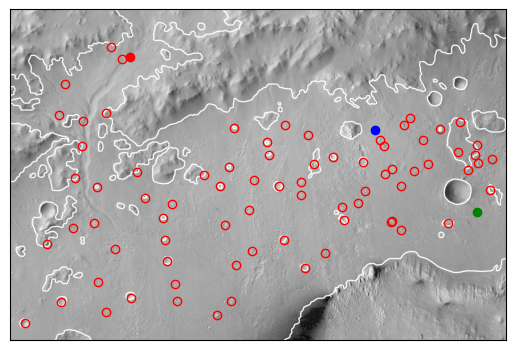

In [3]:
mars_grid.plot_on([P0p,P1p,P2p], 
                  landmarks=True, submap=False)

<h2><center> Task 1: Navigation </center></h2> 

The first task requires the determination of the trajectory from  &#128994; $P_0$ to &#128309; $P_1$. We also need to arrive at the target with an heading $\theta_f$  = 180, while we start with an heading of $\theta_0$ = 90. The heading angle is measured by considering positive an anti-clockwise rotation from the __x__-axis (i.e. $\theta_0$ is parallel to the North direction.)  


For this problem then our state is going to be represented with a 3x1 vector:



<center>

__q__ = $\begin{bmatrix} x \\ y \\ \theta \end{bmatrix}$ and    $\dot{q}$ =  $\begin{bmatrix} \dot{x} \\ \dot{y} \\ \dot{\theta} \end{bmatrix}$

</center>



Through the definition of the kinematical model as 

<center>

 $\dot{q}$ = $\begin{bmatrix} \dot{x} \\ \dot{y} \\ \dot{\theta} \end{bmatrix}$ = $\begin{bmatrix} v\cos{\theta} \\ v\sin{\theta} \\ {\frac{v}{L}\tan{\gamma}}  \end{bmatrix}$ 

</center>

with <b>v</b> speed of the rover and $\bold{\gamma}$ steering angle, we can then control the rover and follow the desired trajectory, retrieving the state with a simple integration.



We first run the __A*__ algorithm to have an idea on how much does it cost the minimum expensive path from $P_0$ to $P_1$, plotting the result on the map.

In [4]:
# A* algorithm from P0 to P1
path, gScore = AStar(mars_grid, tuple(P0), tuple(P1)) 
np_path = np.array(path)
print("A* cost: ", gScore)

A* cost:  12383.46463280844


To achieve a realizable trajectory we employ the <b>Moving to a pose</b> control scheme, implemented in the `control_pose` function.  

The values here used for $k_\rho$, $k_\alpha$, and $k_\beta$ are handpicked to achieve the requisite of not entering the forbidden regions marked on the map.

In [5]:
# Find trajectory via manual tuning of control_pose gains

Curiosity_rover = Rover(maxVel, LAxis)

np_P0 = np.array([P0[0],P0[1], theta0])
np_P1 = np.array([P1[0],P1[1], theta1])

q, qd, t  = control_pose(Curiosity_rover, np_P0, np_P1, 1, 
                         k_rho=0.04, k_alpha=0.09, k_beta=-0.115)

cost_traj = cost_path(q[:,0:2])
print("Cost of the trajectory: ", cost_traj)    
print("Time in sols: ", t/sol_in_secs)
print("Theta: ", np.rad2deg(q[-1,2]))

Stable: k_rho, k_alpha, k_beta = (0.04, 0.09, -0.115)
Cost of the trajectory:  13244.482120523948
Time in sols:  3.7301727883970917
Theta:  179.99997797261778


The control scheme requires
\begin{cases}
    k_\rho > 0 \\
    k_\beta < 0 \\
    k_\alpha - k\rho > 0
\end{cases}
to guarante stability. The values chosen for [$k_\rho$, $k_\alpha$, $k_\beta$], that are [0.04, 0.09, -0.115], satisfy this requirement. 

The total length of the path is only increased by one kilometer compared to the optimal route, which is relatively minimal and acceptable. 

We plot the path on the map:

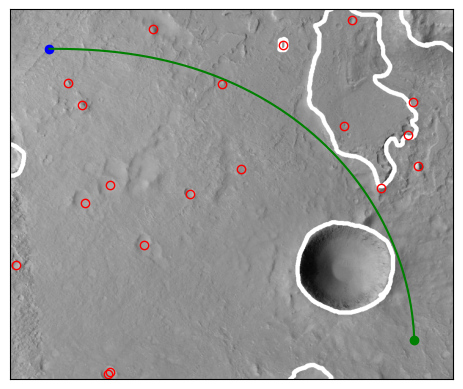

In [6]:
q_path = Path(q[:,0:2], plotArgs='g-')
a_path = Path(np_path, plotArgs='r-')
mars_grid.plot_on([P0p,P1p, q_path], landmarks=True, submap=True)

We now plot the velocity profile of the path:




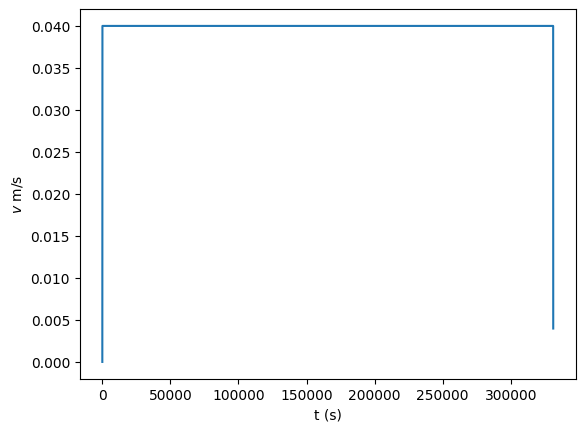

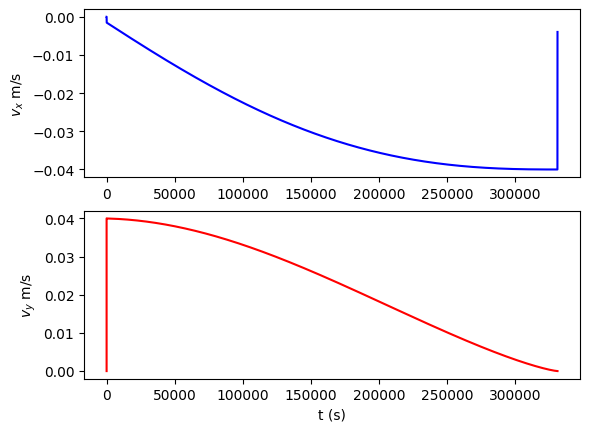

In [7]:
### 1.2) Plot the velocity profile of the rover
plot_velocity(qd)
plt.show()

We see how the control outputs a constant velocity equal to the maximum velocity of the rover. We find this behavior the optimal one, minimiziming the travel time.

The velocity components are also plotted, behaving perfectly with respect to the desired target angle. (Mettila meglio)

The heading and heading rate are shown in the following plots:

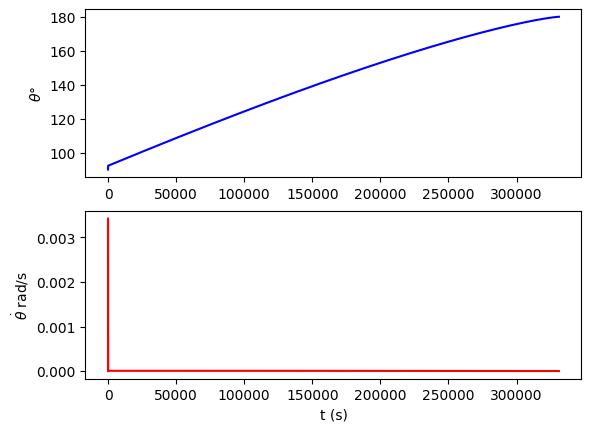

In [8]:
plot_angle_and_rate(q, qd)
plt.show()

We see how the control quickly adjusts the initial heading and then with $\dot{\theta} \simeq 10^{-6}$ rad/s it keeps adjusting the heading along the trajectory.

This trajectory successfully meets the requirements for the final pose and avoids boundary crossing. However, it will be a poor choice for the localization task as the path approaches the forbidden regions closely, which could pose a challenge when considering positional uncertainty and measurement noise. Furthermore, there are few landmarks encountered along this trajectory.   

In Task 3 (Localization), we will explore and construct a more optimal path for localization.

<h2><center> Task 2: Pathfinding </center></h2> 

We are now tasked to navigate from &#128994; $P_1$ to &#128308; $P_2$. We employ the `A*` algorithm in order to satisfy the request.

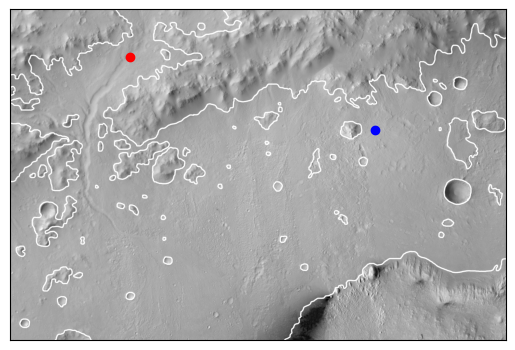

In [9]:
mars_grid.plot_on([P1p, P2p], landmarks=False, submap=False)



The path we will execute should minimize the cost function

\begin{equation*}
    f(n) = G(n) + h(n)
\end{equation*}

where `n` is the next node of the path, G(`n`) is the length of the path from the start to `n` and h(`n`) is the heuristic function evaluated as:

\begin{equation*}
    h(n) = max(dx,dy) + (\sqrt{2} - 1)min(dx,dy)
\end{equation*}
with
\begin{equation*}
    dx = |x_n - x_{goal}| , \quad dy = |y_n - y_{goal}|
\end{equation*}

The implementantion of the A* function is in `Astar.py`, and here shown in bits.


> ```python
>
> from queue import PriorityQueue
> from collections import defaultdict
> def AStar(grid, x0, x_target):
>     open_set = PriorityQueue()
>     cameFrom = {}
> 
>     gScore = defaultdict(lambda: float('inf')) # If value not in dict, return inf
>     gScore[x0] = 0
>     fScore = defaultdict(lambda: float('inf'))
>     fScore[x0] = h_oct(x0, x_target)
>     open_set.put((fScore[x0], h_oct(x0, x_target), x0))
> 
>```

We start by importing `PriorityQueue` and `defaultdict` from standard Python libraries. 

`PriorityQueue` ensures that the node returned by `open_set.get()` will be the one with the lowest f in the set. The heuristic function is used to solve equalities in f.

`defaultdict` lets us define `gScore` and `fScore` computed for each node as a dict, and it will return infinity if the node is not present in the set. We initialize the two sets with the initial position.

> ``` python
> 
>     while not open_set.empty(): 
>         
>         current = open_set.get()[2] # get only the position tuple
>         if current == x_target:
>             # return the path and the cost
>             return reconstruct_path(cameFrom, current), gScore[current]
>        
>         # compute neighbors of current -- deletes points outside of boundary or inside obstacle
>         cur_neighbors = grid.neighbors(current[0], current[1], obstacle_check=True)
>         for neighbor in cur_neighbors:
>            h_temp = h_oct(neighbor, x_target)
>            tentative_gScore = gScore[current] + cost(current, neighbor)
>            tentative_fScore = tentative_gScore + h_temp
> 
>            if tentative_fScore < fScore[neighbor]:
>                 cameFrom[neighbor] = current
>                 gScore[neighbor] = tentative_gScore
>                 fScore[neighbor] = tentative_fScore
>                 open_set.put((fScore[neighbor], h_temp, neighbor))
>
> ```

For each node in `open_set` we firstly check if we're at the target, we return the path. If not, we check our neighbours, and for each of them that do not crosses a boundary we compute its $G(n)$ and $f(n)$, storing them if the the cost function computed at this step is less than its previous one. We then add the neighbour to `open_set`.

We can now compute the optimal path from &#128308; $P_1$ to &#128994; $P_2$

In [10]:
### TASK 2 ### -- 3min average runtime
# Go from P1 to P2

# Run A* from P0 to P1

# P2 = (10.87*10**3, 25.67*10**3)

# path2, gScore2 = AStar(mars_grid, P1, P2) # Run A* from P1 to P2
# np_path2 = np.array(path2)



In [11]:
# ## Plot TASK 2


# plt.text(P0[0]/10, P0[1]/10+50, 'P0', color='blue', fontsize=12)
# plt.text(P1[0]/10, P1[1]/10+70, 'P1', color='red', fontsize=12)
# plt.text(P2[0]/10, P2[1]/10+70, 'P2', color='green', fontsize=12)

# plt.show()
# print("Cost from P0 to P1: ", gScore)
# print("Cost from P1 to P2: ", gScore2)
# print("Total cost: ", gScore + gScore2)


<h2><center> Task 3: Localization </center></h2> 

We are now tasked to perform localization on our rover when it travels from &#128994; $P_0$ to &#128309; $P_1$, assuming we are perfectly following the trajectory computed in Task 1. 

To perform localization, the <b>Dead Reckoning</b> algorithm is implemented, using as measurements the odometer readings, simulated along the travel of the trajectory.  
The reconstrution of the trajectory is going to be succesively refined with a <b> Kalman filter </b>, correcting the Dead Reckoning estimate with measurements of distance from landmarks, done by an onboard lidar sensor.

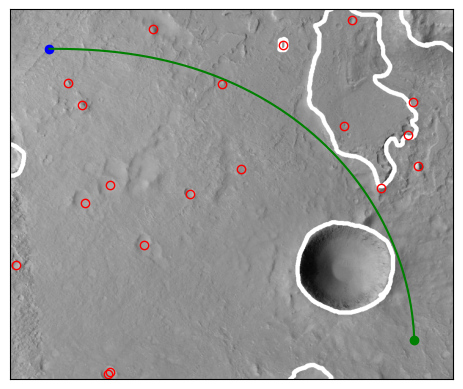

In [12]:
mars_grid.plot_on([P0p, P1p, q_path], landmarks=True, submap=True)

The error on the initial position is given as:


$\begin{bmatrix} 
    \sigma_x \\ \sigma_y \\ \sigma_\theta 
    \end{bmatrix} = 
    \begin{bmatrix}  6m \\ 6m \\ 1 \end{bmatrix}$ so that $P_0 = \begin{bmatrix} 36 & 0 & 0 \\ 0 & 36 & 0 \\ 0 & 0 & 1 \end{bmatrix} $


while the encoder has a noise figure [$\sigma_d$ = 4mm, $\sigma_\theta$ = 0.05] and the lidar [$\sigma_d$ = 0.1m, $\sigma_\beta$ = 0.25].

The assigned odometry frequency of 1Hz is perfectly synchronized with the integration time used in `Task 1`




In [13]:
r_traj = q # trajectory we're on

# Stdev on initial rover position
sigma_x = 6 # [m] standard deviation of the rover position
sigma_y = 6 # [m] *standard deviation of the rover position
sigma_theta = np.deg2rad(1) # [rad] standard deviation of the rover orientation

# odometer noise 
sigma_d  = 4*10**(-3) # [m] standard deviation of the distance measurement
sigma_phi = np.deg2rad(0.05) # [rad] standard deviation of the angle measurement

p0 = np.eye(3)*[sigma_x**2, sigma_y**2, sigma_theta**2] # initial covariance matrix

The trajectory is discretized in order to use odometry, allowing us the use of the following relations to propagate the estimated trajectory:

\begin{cases}
    x_{k+1}  = x_k + \delta_d \cos{\theta} \\
    y_{k+1}  = y_k + \delta_d \sin{\theta} \\
    \theta_{k+1} = \theta_k + \delta_{\theta} 
\end{cases}
where $\delta_d$, $\delta_{\theta}$ are the noisy measurements coming from the odometer. 

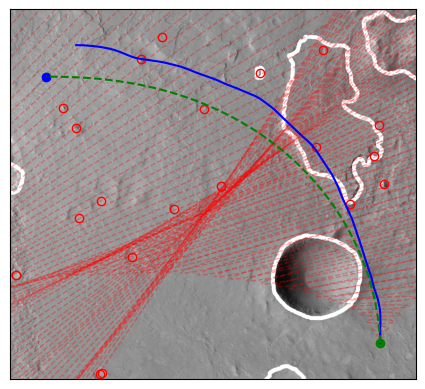

In [14]:
dr_traj, dr_p = dead_recon(r_traj, p0, sigma_d, sigma_phi)
# Plot the dead reckoning trajectory
q_path.set_plotArgs('g--')
dr_path = Path(dr_traj[:,0:2], np_state_un = dr_p[:,0:2, 0:2], plotArgs='b-')
mars_grid.plot_on([P0p, P1p, dr_path, q_path], landmarks=True, submap=True, uncertainty=True)

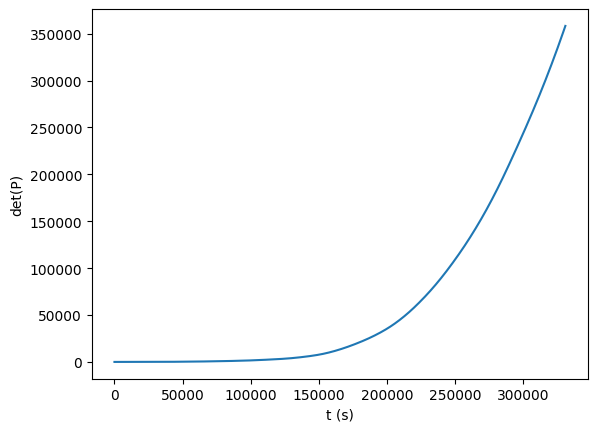

In [15]:
plot_detP(dr_p)

We obviously see how the uncertainty on the position grows as we move along the trajectory. This is unevitable with only Dead Reckoning.  

A Kalman filter is used to try to decrease the uncertainty, using the lidar to measure distance and angle between the landmarks on the territory.

In [16]:
# Dead reckoning with odomoter + landmark measurements
lidar_range = 500 # [m] maximum range of the lidar
sigma_rho = 0.1 # [m] standard deviation of the rho measurement
sigma_beta = np.deg2rad(0.25) # [rad] standard deviation of the beta measurement

# problematic landmark at [array([37482., 18113.])]
# first landmark at [array([41542., 15452.])] -- idx = 89663
ekf_grid = mars_grid.submap_path([P0, P1], right_spacing=9999)

ekf_traj, ekf_p = EKF(ekf_grid, r_traj, p0, 
                      sigma_d, sigma_phi, 
                      sigma_rho, sigma_beta, lidar_range)

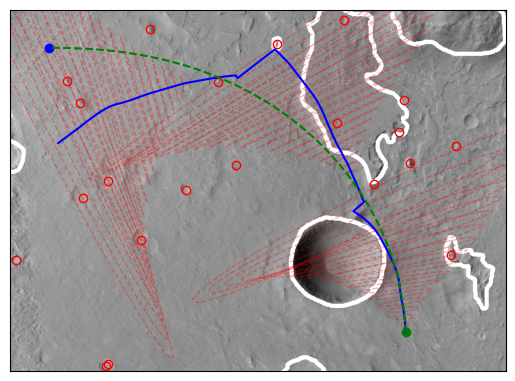

In [17]:
ekf_path = Path(ekf_traj[:,0:2], ekf_p[:,0:2,0:2],'b-')
ekf_grid.plot_on([P0p, P1p, ekf_path, q_path], 
                  landmarks=True, uncertainty=True)

In [18]:

# # step in ekf_traj with a step of 1000
# for i in range(0, len(ekf_traj), 5000):
#     ellipse = error_ellipse(ekf_traj[i,0]/10 - submap.x_off/10, ekf_traj[i,1]/10 - submap.y_off/10, ekf_p[i][0:2,0:2])
#     ax.add_artist(ellipse)
#     ellipse.set_alpha(0.3)
#     ellipse.set_facecolor('none')
#     ellipse.set_edgecolor('r')
#     ellipse.set_linestyle('--')

# plt.show()

Stable: k_rho, k_alpha, k_beta = (0.04, 0.09, -0.115)
Stable: k_rho, k_alpha, k_beta = (0.04, 0.09, -0.055)


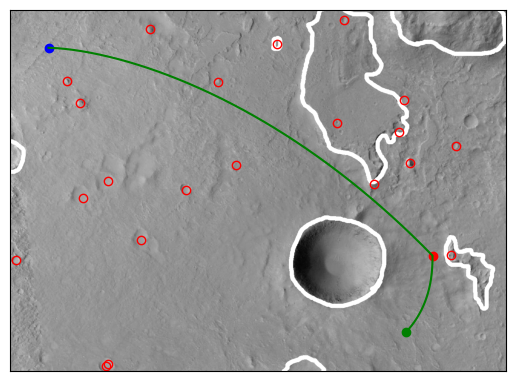

In [19]:
Pvia = np.array([P0[0]+700,P0[1]+2000])
np_Pvia = np.array([Pvia[0],Pvia[1], theta0])


Pviap = Path(Pvia, plotArgs='ro')


# control_pose
q_via, qd_via, t_via  = control_pose(Curiosity_rover, np_P0, np_Pvia, 1, 
                        k_rho=0.04, k_alpha=0.09, k_beta=-0.115)
q_tar, qd_tar, t_tar  = control_pose(Curiosity_rover, np_Pvia, np_P1, 1, 
                         k_rho=0.04, k_alpha=0.09, k_beta=-0.055)

q_new = np.vstack((q_via, q_tar))
qd_new = np.vstack((qd_via, qd_tar))
t_new = t_via + t_tar

q_new_path = Path(q_new[:,0:2], plotArgs='g--')
ekf_grid.plot_on([P0p, P1p, Pviap, Path(q_new[:,0:2], plotArgs='g-')], landmarks=True)

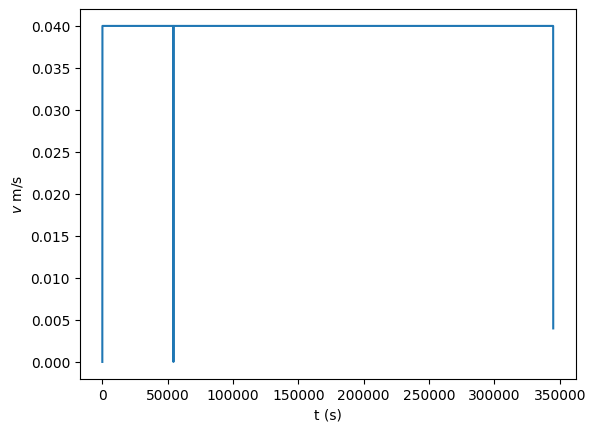

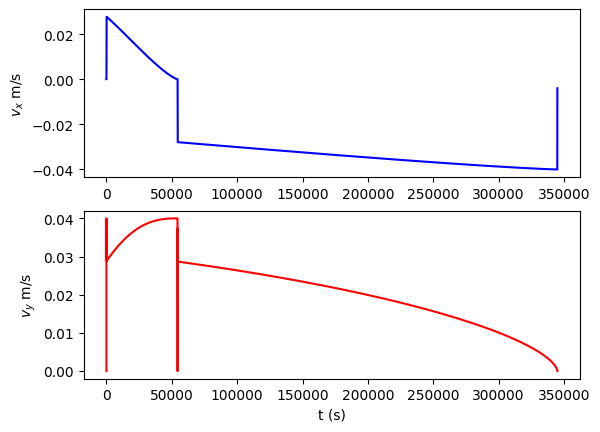

In [22]:
### 1.2) Plot the velocity profile of the rover
plot_velocity(qd_new)
plt.show()

In [20]:
ekf_traj, ekf_p = EKF(ekf_grid, q_new, p0, 
                      sigma_d, sigma_phi, 
                      sigma_rho, sigma_beta, lidar_range)


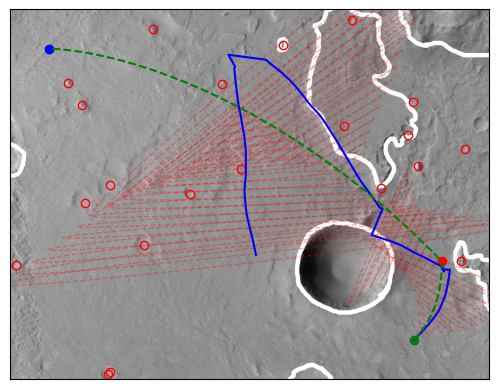

In [21]:
ekf_path = Path(ekf_traj[:,0:2], ekf_p[:,0:2,0:2],'b-')
mars_grid.plot_on([P0p, P1p, Pviap, ekf_path, q_new_path], 
                  landmarks=True, uncertainty=True, submap=True)